In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import ad_server
import distributions
import simulation

In [2]:
windows = 24 * 60
requests = 20_000

base_distribution = distributions.custom_dist(windows)
requests_distribution = distributions.traffic_dist(base_distribution, requests)
campaigns = [ad_server.Campaign(1, 900, 1), ad_server.Campaign(2, 1_800, 2)]
pacing = ad_server.ThrottledPacing(base_distribution, 2 * 60)
# select_win = pacing.first_price_auction
select_win = ad_server.second_price_auction
process = ad_server.AdServer(pacing, select_win, campaigns)

In [3]:
sim = simulation.Simulation(requests_distribution, process)

In [4]:
df = pd.DataFrame(e.to_dict() for e in sim.run())

In [5]:
win_values_df = df[df["kind"] == "win"].set_index(["request", "window", "campaign_id"]).unstack()["bid_value"]

In [6]:
win_values_in_windows_df = win_values_df.fillna(0).groupby("window").sum()

In [7]:
total_win_value_df = win_values_in_windows_df.sum()

In [8]:
budget_spending_df = win_values_in_windows_df.cumsum() / total_win_value_df

In [9]:
budget_spending_df

campaign_id,1,2
window,,
2,0.000000,0.001111
3,0.000000,0.002222
5,0.001111,0.002222
6,0.002222,0.002222
15,0.003333,0.002222
...,...,...
1357,0.966667,1.000000
1358,0.975556,1.000000
1359,0.985556,1.000000


In [10]:
perfect_budget_spending_df = distributions.normalize(requests_distribution).cumsum()

<AxesSubplot:xlabel='window'>

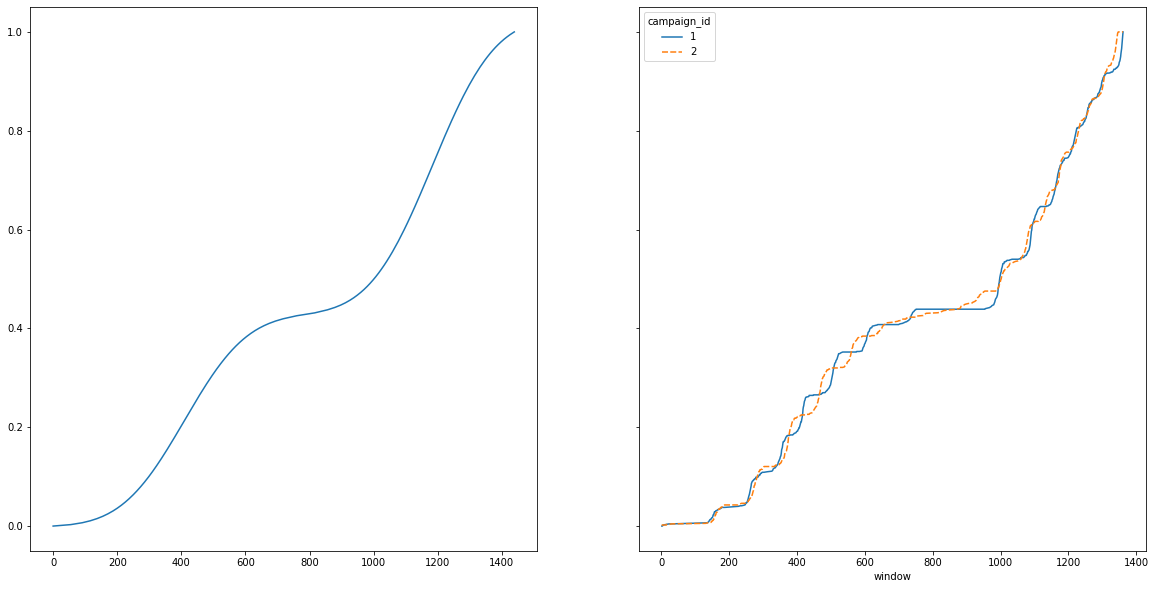

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey="row", figsize=(20, 10))
sns.lineplot(data=perfect_budget_spending_df, ax=ax1)
sns.lineplot(data=budget_spending_df, ax=ax2)

In [12]:
import analysis

analysis.budget_consumption(df, requests_distribution)

value          
campaign_id         1         2
window                         
2            0.000000  0.001111
3            0.000000  0.002222
5            0.001111  0.002222
6            0.002222  0.002222
15           0.003333  0.002222
...               ...       ...
1357         0.966667  1.000000
1358         0.975556  1.000000
1359         0.985556  1.000000
1360         0.992222  1.000000
1361         1.000000  1.000000

[728 rows x 2 columns]

In [13]:
df

,request,window,request_in_window,kind,campaign_id,bid_value
0,0,0,0,no bid,1,0
1,0,0,0,no bid,2,0
2,0,0,0,no win,0,0
3,1,1,0,no bid,1,0
4,1,1,0,no bid,2,0
...,...,...,...,...,...,...
59992,19997,1439,6,no bid,2,0
59993,19997,1439,6,no win,0,0
59994,19998,1439,7,no bid,1,0
59995,19998,1439,7,no bid,2,0


In [14]:
win_df = df[df["kind"] == "win"]

In [15]:
import numpy as np

window_df = win_df.groupby("campaign_id").aggregate(min_window=("window", np.min), max_window=("window", np.max), unique_windows=("window", lambda s: len(s.unique())))

In [16]:
window_df["width"] = window_df["max_window"] - window_df["min_window"]

In [17]:
window_df

,min_window,max_window,unique_windows,width
campaign_id,,,,
1,5,1361,444,1356
2,2,1347,497,1345


<AxesSubplot:>

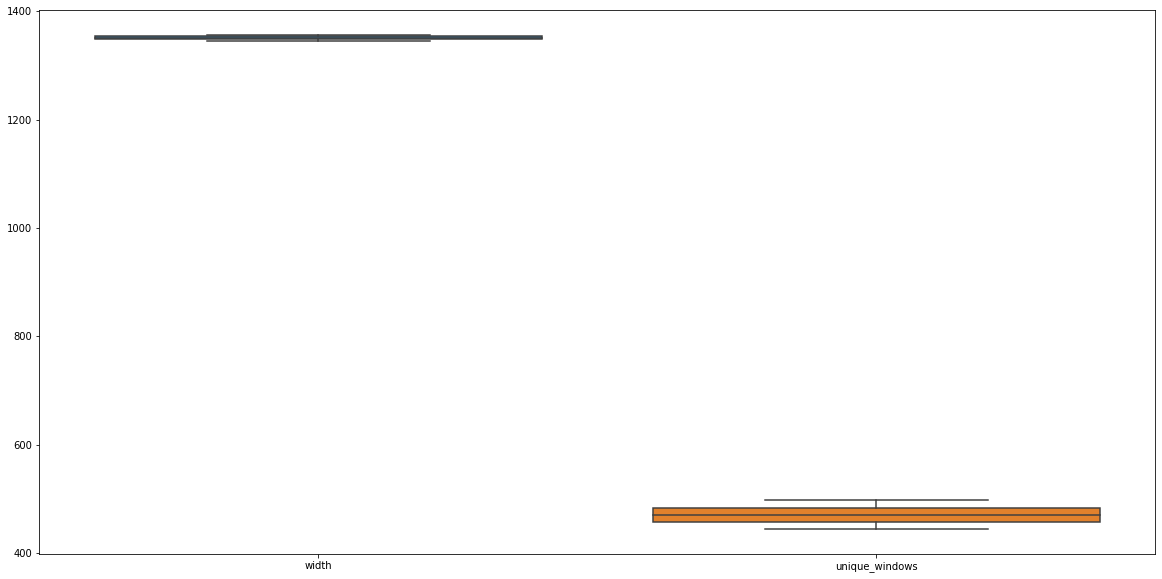

In [18]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=window_df[["width", "unique_windows"]])

In [19]:
win_df["bid_value"].sum()

2700

In [20]:
win_df["bid_value"].mean()

1.4770240700218817

In [21]:
df

,request,window,request_in_window,kind,campaign_id,bid_value
0,0,0,0,no bid,1,0
1,0,0,0,no bid,2,0
2,0,0,0,no win,0,0
3,1,1,0,no bid,1,0
4,1,1,0,no bid,2,0
...,...,...,...,...,...,...
59992,19997,1439,6,no bid,2,0
59993,19997,1439,6,no win,0,0
59994,19998,1439,7,no bid,1,0
59995,19998,1439,7,no bid,2,0


In [22]:
# not served requests
df[df["kind"] == "no win"].shape[0]

18171

In [23]:
win_df = df[df["kind"].isin(["win", "no win"])].groupby(["window", "kind"]).aggregate(requests=("request", np.size)).unstack(fill_value=0)

In [24]:
no_win_windows_df = win_df[(win_df[("requests", "no win")] > 0) & (win_df[("requests", "win")] == 0)]

In [25]:
# windows without any request being served
no_win_windows_df.shape[0]

712